# ML algorithm spot check 

Table of Contents
1. [Read in cleaned data](#cleaned)
1. [Spot check XGBoost](#xgboost)
1. [Spot check Multilayer Perceptron](#mlp)

## Read in the cleansed data <a name="cleaned"></a>

In [1]:
import pandas as pd
import numpy as np
import sklearn

In [2]:
prepared_data_dir = 'data/processed'

In [3]:
processed = pd.read_pickle("{}/cooked_v3.pkl".format (prepared_data_dir))

In [4]:
processed.info ()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1502293 entries, 2017-07-03 08:00:00 to 2017-07-31 20:00:00
Data columns (total 14 columns):
StartPrice        1502293 non-null float64
MaxPrice          1502293 non-null float64
MinPrice          1502293 non-null float64
EndPrice          1502293 non-null float64
TradedVolume      1502293 non-null float64
NumberOfTrades    1502293 non-null float64
HourOfDay         1502293 non-null int64
MinOfHour         1502293 non-null int64
MinOfDay          1502293 non-null int64
DayOfWeek         1502293 non-null int64
DayOfYear         1502293 non-null int64
MonthOfYear       1502293 non-null int64
WeekOfYear        1502293 non-null int64
Mnemonic          1502293 non-null category
dtypes: category(1), float64(6), int64(7)
memory usage: 161.9 MB


In [5]:
processed.sample(5)

,StartPrice,MaxPrice,MinPrice,EndPrice,TradedVolume,NumberOfTrades,HourOfDay,MinOfHour,MinOfDay,DayOfWeek,DayOfYear,MonthOfYear,WeekOfYear,Mnemonic
CalcDateTime,,,,,,,,,,,,,,
2017-07-03 13:39:00,34.535,34.535,34.535,34.535,100.0,1.0,13,39,819,0,184,7,27,DEQ
2017-07-13 17:08:00,71.900,71.900,71.890,71.900,0.0,0.0,17,8,1028,3,194,7,28,OSR
2017-07-06 14:22:00,1.059,1.059,1.059,1.059,0.0,0.0,14,22,862,3,187,7,27,TINA
2017-07-10 09:51:00,5.488,5.490,5.488,5.490,0.0,0.0,9,51,591,0,191,7,28,NOA3
2017-07-21 08:35:00,4.541,4.541,4.541,4.541,373.0,1.0,8,35,515,4,202,7,29,SNH


In [6]:
processed.head (5)

,StartPrice,MaxPrice,MinPrice,EndPrice,TradedVolume,NumberOfTrades,HourOfDay,MinOfHour,MinOfDay,DayOfWeek,DayOfYear,MonthOfYear,WeekOfYear,Mnemonic
CalcDateTime,,,,,,,,,,,,,,
2017-07-03 08:00:00,15.830,15.830,15.820,15.825,6594.0,9.0,8,0,480,0,184,7,27,DBK
2017-07-03 08:01:00,15.835,15.835,15.795,15.800,120179.0,29.0,8,1,481,0,184,7,27,DBK
2017-07-03 08:02:00,15.800,15.805,15.775,15.785,32404.0,29.0,8,2,482,0,184,7,27,DBK
2017-07-03 08:03:00,15.785,15.815,15.785,15.805,34169.0,58.0,8,3,483,0,184,7,27,DBK
2017-07-03 08:04:00,15.805,15.805,15.795,15.805,26589.0,31.0,8,4,484,0,184,7,27,DBK


In [7]:
selected = processed[processed['Mnemonic'].isin(['EOAN', 'BMW', 'SAP'])]
selected.Mnemonic.cat.remove_unused_categories (inplace=True)

In [8]:
selected.head(5)

,StartPrice,MaxPrice,MinPrice,EndPrice,TradedVolume,NumberOfTrades,HourOfDay,MinOfHour,MinOfDay,DayOfWeek,DayOfYear,MonthOfYear,WeekOfYear,Mnemonic
CalcDateTime,,,,,,,,,,,,,,
2017-07-03 08:00:00,8.293,8.301,8.293,8.298,13532.0,12.0,8,0,480,0,184,7,27,EOAN
2017-07-03 08:01:00,8.297,8.297,8.297,8.297,264.0,1.0,8,1,481,0,184,7,27,EOAN
2017-07-03 08:02:00,8.300,8.300,8.284,8.285,5180.0,9.0,8,2,482,0,184,7,27,EOAN
2017-07-03 08:03:00,8.286,8.293,8.282,8.285,20331.0,29.0,8,3,483,0,184,7,27,EOAN
2017-07-03 08:04:00,8.282,8.285,8.279,8.282,11333.0,27.0,8,4,484,0,184,7,27,EOAN


## Forecast with XGBoost <a name="xgboost"></a>

In [9]:
!pip install xgboost

    100% |████████████████████████████████| 16.6MB 2.9MB/s 
You are using pip version 10.0.1, however version 19.0.3 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [10]:
import xgboost

In [11]:
def create_xgb_target (df):
    return df.MaxPrice.shift(-1).fillna (method='ffill')

In [12]:
def create_xgb_features (df, horizon):
    n_df = df.copy ()
    
    for offset in range(1, horizon+1):
        min_price = n_df['MinPrice'].shift (offset).fillna(method='bfill')
        max_price = n_df['MaxPrice'].shift (offset).fillna(method='bfill')
        start_price = n_df['StartPrice'].shift (offset).fillna(method='bfill')
        end_price = n_df['EndPrice'].shift (offset).fillna(method='bfill')
        trade_vol = n_df['TradedVolume'].shift (offset).fillna(method='bfill')
        num_trades = n_df['NumberOfTrades'].shift (offset).fillna(method='bfill')
        
        n_df["h{}_MinPrice".format (offset)] = min_price
        n_df["h{}_MaxPrice".format (offset)] = max_price
        n_df["h{}_StartPrice".format (offset)] = start_price
        n_df["h{}_EndPrice".format (offset)] = end_price
        n_df["h{}_TradeVolume".format (offset)] = trade_vol
        n_df["h{}_NumberOfTrades".format (offset)] = num_trades
        
    return n_df

In [13]:
xgb_data = create_xgb_features (selected, 5)
xgb_data['NextMaxPrice'] = create_xgb_target (xgb_data)
pd.options.display.max_columns=150
xgb_data.head(5)

,StartPrice,MaxPrice,MinPrice,EndPrice,TradedVolume,NumberOfTrades,HourOfDay,MinOfHour,MinOfDay,DayOfWeek,DayOfYear,MonthOfYear,WeekOfYear,Mnemonic,h1_MinPrice,h1_MaxPrice,h1_StartPrice,h1_EndPrice,h1_TradeVolume,h1_NumberOfTrades,h2_MinPrice,h2_MaxPrice,h2_StartPrice,h2_EndPrice,h2_TradeVolume,h2_NumberOfTrades,h3_MinPrice,h3_MaxPrice,h3_StartPrice,h3_EndPrice,h3_TradeVolume,h3_NumberOfTrades,h4_MinPrice,h4_MaxPrice,h4_StartPrice,h4_EndPrice,h4_TradeVolume,h4_NumberOfTrades,h5_MinPrice,h5_MaxPrice,h5_StartPrice,h5_EndPrice,h5_TradeVolume,h5_NumberOfTrades,NextMaxPrice
CalcDateTime,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2017-07-03 08:00:00,8.293,8.301,8.293,8.298,13532.0,12.0,8,0,480,0,184,7,27,EOAN,8.293,8.301,8.293,8.298,13532.0,12.0,8.293,8.301,8.293,8.298,13532.0,12.0,8.293,8.301,8.293,8.298,13532.0,12.0,8.293,8.301,8.293,8.298,13532.0,12.0,8.293,8.301,8.293,8.298,13532.0,12.0,8.297
2017-07-03 08:01:00,8.297,8.297,8.297,8.297,264.0,1.0,8,1,481,0,184,7,27,EOAN,8.293,8.301,8.293,8.298,13532.0,12.0,8.293,8.301,8.293,8.298,13532.0,12.0,8.293,8.301,8.293,8.298,13532.0,12.0,8.293,8.301,8.293,8.298,13532.0,12.0,8.293,8.301,8.293,8.298,13532.0,12.0,8.300
2017-07-03 08:02:00,8.300,8.300,8.284,8.285,5180.0,9.0,8,2,482,0,184,7,27,EOAN,8.297,8.297,8.297,8.297,264.0,1.0,8.293,8.301,8.293,8.298,13532.0,12.0,8.293,8.301,8.293,8.298,13532.0,12.0,8.293,8.301,8.293,8.298,13532.0,12.0,8.293,8.301,8.293,8.298,13532.0,12.0,8.293
2017-07-03 08:03:00,8.286,8.293,8.282,8.285,20331.0,29.0,8,3,483,0,184,7,27,EOAN,8.284,8.300,8.300,8.285,5180.0,9.0,8.297,8.297,8.297,8.297,264.0,1.0,8.293,8.301,8.293,8.298,13532.0,12.0,8.293,8.301,8.293,8.298,13532.0,12.0,8.293,8.301,8.293,8.298,13532.0,12.0,8.285
2017-07-03 08:04:00,8.282,8.285,8.279,8.282,11333.0,27.0,8,4,484,0,184,7,27,EOAN,8.282,8.293,8.286,8.285,20331.0,29.0,8.284,8.300,8.300,8.285,5180.0,9.0,8.297,8.297,8.297,8.297,264.0,1.0,8.293,8.301,8.293,8.298,13532.0,12.0,8.293,8.301,8.293,8.298,13532.0,12.0,8.283


In [14]:
from sklearn.model_selection import train_test_split
train_data, test_data = train_test_split (xgb_data, train_size=0.8, shuffle=False)
train_data, validate_data = train_test_split (train_data, train_size=0.8, test_size=0.2, shuffle=True)

train_labels = train_data.NextMaxPrice
validate_labels = validate_data.NextMaxPrice
test_labels = test_data.NextMaxPrice

/home/ec2-user/anaconda3/envs/mxnet_p36/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2069: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


In [15]:
train_data.drop ("NextMaxPrice", axis=1, inplace=True)
validate_data.drop ("NextMaxPrice", axis=1, inplace=True)
test_data.drop ('NextMaxPrice', axis = 1, inplace=True)

/home/ec2-user/anaconda3/envs/mxnet_p36/lib/python3.6/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


In [16]:
train_features = pd.get_dummies(train_data)
validate_features = pd.get_dummies(validate_data)
test_features = pd.get_dummies(test_data)
train_features.head(5)

,StartPrice,MaxPrice,MinPrice,EndPrice,TradedVolume,NumberOfTrades,HourOfDay,MinOfHour,MinOfDay,DayOfWeek,DayOfYear,MonthOfYear,WeekOfYear,h1_MinPrice,h1_MaxPrice,h1_StartPrice,h1_EndPrice,h1_TradeVolume,h1_NumberOfTrades,h2_MinPrice,h2_MaxPrice,h2_StartPrice,h2_EndPrice,h2_TradeVolume,h2_NumberOfTrades,h3_MinPrice,h3_MaxPrice,h3_StartPrice,h3_EndPrice,h3_TradeVolume,h3_NumberOfTrades,h4_MinPrice,h4_MaxPrice,h4_StartPrice,h4_EndPrice,h4_TradeVolume,h4_NumberOfTrades,h5_MinPrice,h5_MaxPrice,h5_StartPrice,h5_EndPrice,h5_TradeVolume,h5_NumberOfTrades,Mnemonic_BMW,Mnemonic_EOAN,Mnemonic_SAP
CalcDateTime,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2017-07-19 10:52:00,8.483,8.485,8.483,8.484,10544.0,10.0,10,52,652,2,200,7,29,8.481,8.483,8.483,8.482,6805.0,4.0,8.484,8.485,8.485,8.484,22069.0,21.0,8.483,8.486,8.483,8.485,22961.0,22.0,8.484,8.488,8.488,8.484,8802.0,6.0,8.488,8.491,8.488,8.490,15191.0,10.0,0,1,0
2017-07-17 19:07:00,91.010,91.060,91.010,91.050,0.0,0.0,19,7,1147,0,198,7,29,91.010,91.060,91.010,91.050,0.0,0.0,91.010,91.060,91.010,91.050,0.0,0.0,91.010,91.060,91.010,91.050,0.0,0.0,91.010,91.060,91.010,91.050,0.0,0.0,91.010,91.060,91.010,91.050,0.0,0.0,0,0,1
2017-07-18 09:50:00,8.537,8.537,8.537,8.537,996.0,1.0,9,50,590,1,199,7,29,8.533,8.535,8.533,8.535,4392.0,7.0,8.534,8.534,8.534,8.534,2550.0,4.0,8.535,8.537,8.537,8.535,7720.0,10.0,8.538,8.542,8.542,8.538,5890.0,11.0,8.542,8.545,8.545,8.543,0.0,0.0,0,1,0
2017-07-05 15:02:00,81.390,81.400,81.370,81.400,1910.0,14.0,15,2,902,2,186,7,27,81.300,81.380,81.300,81.370,3509.0,28.0,81.280,81.310,81.280,81.310,2622.0,15.0,81.270,81.320,81.310,81.280,2579.0,22.0,81.290,81.310,81.290,81.310,2675.0,16.0,81.290,81.310,81.310,81.290,1684.0,7.0,1,0,0
2017-07-06 17:55:00,8.088,8.089,8.074,8.080,0.0,0.0,17,55,1075,3,187,7,27,8.074,8.089,8.088,8.080,0.0,0.0,8.074,8.089,8.088,8.080,0.0,0.0,8.074,8.089,8.088,8.080,0.0,0.0,8.074,8.089,8.088,8.080,0.0,0.0,8.074,8.089,8.088,8.080,0.0,0.0,0,1,0


In [17]:
model = xgboost.XGBRegressor (n_estimators=500)
model.fit (train_features, train_labels, 
           eval_set=[(train_features, train_labels), (validate_features, validate_labels)],
           early_stopping_rounds = 50, verbose=False)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=500,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

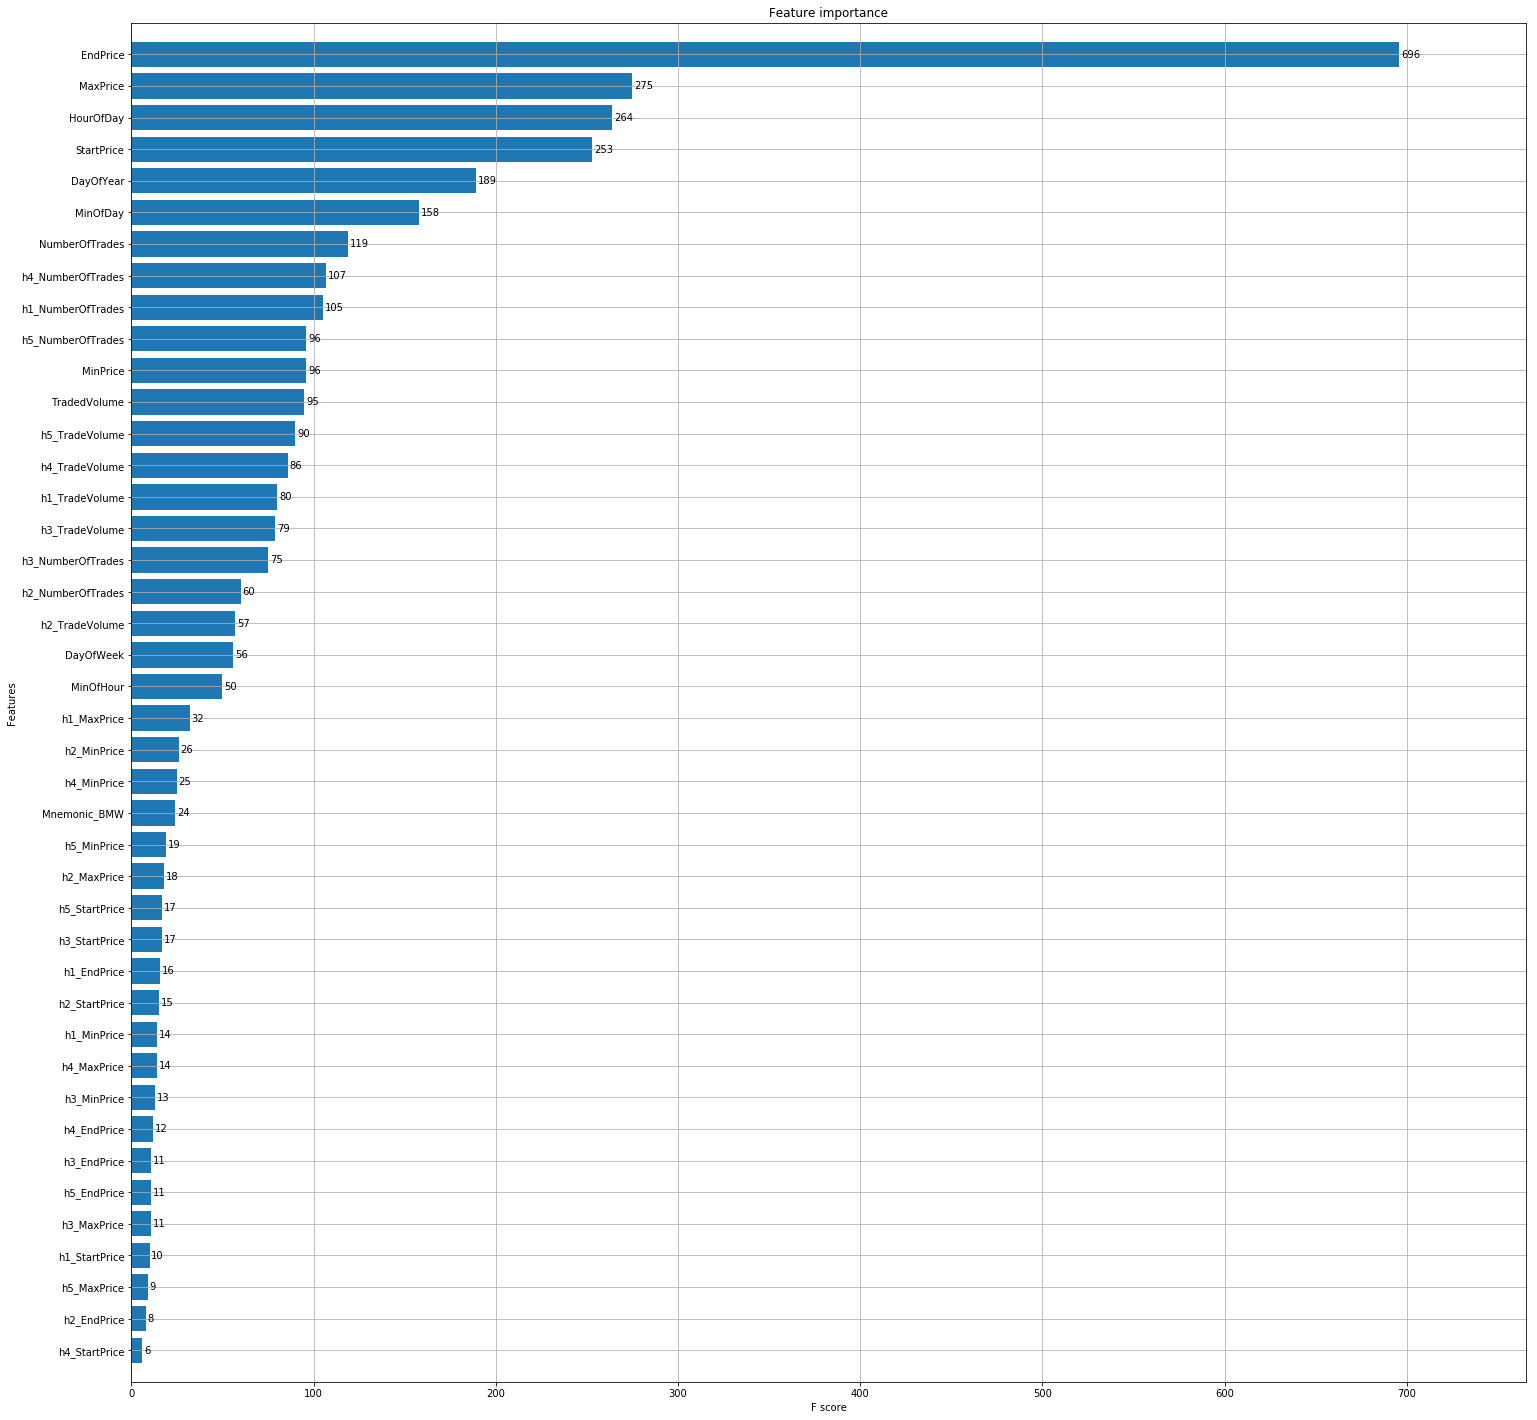

In [18]:
%matplotlib inline
from matplotlib import pyplot as plt
from xgboost import plot_importance
fig, ax = plt.subplots(1,1,figsize=(25,25))
plot_importance(model, height=0.8, ax=ax)

In [19]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
pred = model.predict (test_features)
print ("RMSE: {}".format (mean_squared_error (y_true = test_labels, y_pred = pred)))
print ("MAE: {}".format (mean_absolute_error (y_true = test_labels, y_pred = pred)))

RMSE: 2.087893778186076
MAE: 0.9517232656610102


In [20]:
test_labels.index.get_loc('2017-07-14 08:00:00')

433

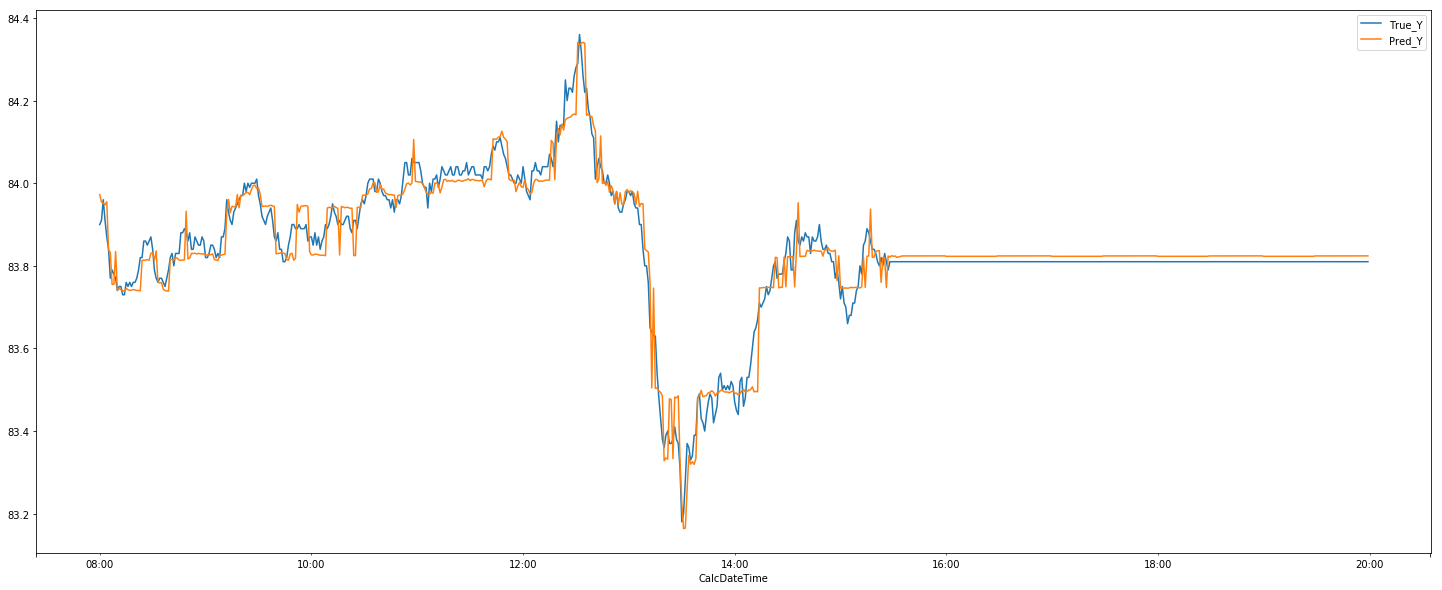

In [21]:
from matplotlib import pyplot as plt

start_loc = test_labels.index.get_loc('2017-07-14 08:00:00')
end_loc = test_labels.index.get_loc('2017-07-14 20:00:00')
data = pd.DataFrame ()
data['True_Y'] = test_labels[start_loc:end_loc]
data['Pred_Y'] = pred[start_loc:end_loc]

data.plot (figsize=(25,10))

## Forecasting with an MLP <a name="mlp"></a>

In [22]:
import mxnet as mx
from mxnet import nd, autograd, gluon

In [23]:
num_hidden_1 = 64
num_hidden_2 = 24
num_output = 1
learning_rate = 0.001
batch_size = 100
num_examples = 33233

model_ctx = mx.cpu ()
data_ctx = mx.cpu ()

In [24]:
train_dataset = gluon.data.dataset.ArrayDataset (nd.array(train_features), nd.array(train_labels))
train_dataloader = gluon.data.DataLoader (train_dataset, batch_size=batch_size)

validate_dataset = gluon.data.dataset.ArrayDataset (nd.array(validate_features), nd.array(validate_labels))
validate_dataloader = gluon.data.DataLoader (validate_dataset, batch_size=batch_size)

test_dataset = gluon.data.dataset.ArrayDataset (nd.array(test_features), nd.array(test_labels))
test_dataloader = gluon.data.DataLoader (test_dataset, batch_size=batch_size)

In [25]:
model = gluon.nn.Sequential ()
with model.name_scope ():
    model.add (gluon.nn.Dense (num_hidden_1, activation='relu'))
    model.add (gluon.nn.Dense (num_hidden_2, activation='relu'))
    model.add (gluon.nn.Dense (num_output))
    
model.collect_params().initialize(mx.init.Normal(sigma=.1), ctx=model_ctx)
l2loss = gluon.loss.L2Loss ()
trainer = gluon.Trainer(model.collect_params(), 'adam', {'learning_rate': learning_rate})


In [26]:
def evaluate_accuracy(data_iterator, model):
    rmse = mx.metric.RMSE ()
    for i, (data, label) in enumerate(data_iterator):
        data = data.as_in_context(model_ctx).reshape((-1, 46))
        label = label.as_in_context(model_ctx)
        output = model(data)
        predictions = output # predictions = nd.argmax(output, axis=1)
        rmse.update(preds=predictions, labels=label)
    return rmse.get()[1]

In [27]:
epochs = 50
smoothing_constant = .01

for e in range(epochs):
    cumulative_loss = 0
    for i, (data, label) in enumerate(train_dataloader):
        data = data.as_in_context(model_ctx).reshape((-1, 46))
        label = label.as_in_context(model_ctx)
        with autograd.record():
            output = model(data)
            loss = l2loss(output, label)
        loss.backward()
        trainer.step(data.shape[0])
        cumulative_loss += nd.sum(loss).asscalar()

    validate_accuracy = evaluate_accuracy(validate_dataloader, model)
    train_accuracy = evaluate_accuracy(train_dataloader, model)
    print("Epoch %s. Loss: %s, Train_acc %s, Validate_acc %s" %
          (e, cumulative_loss/num_examples, train_accuracy, validate_accuracy))

Epoch 0. Loss: 1962.963911236102, Train_acc 27.4207754987212, Validate_acc 28.85848260905645
Epoch 1. Loss: 205.47536626750426, Train_acc 22.250806126807564, Validate_acc 22.777545471713967
Epoch 2. Loss: 176.13024672036266, Train_acc 19.08598838557083, Validate_acc 19.697416801975198
Epoch 3. Loss: 133.25862023646252, Train_acc 14.094971853433195, Validate_acc 14.351780519093552
Epoch 4. Loss: 112.6757434788381, Train_acc 13.860201052374038, Validate_acc 13.439384375533013
Epoch 5. Loss: 96.95291852768827, Train_acc 12.094614399257804, Validate_acc 11.578186414013171
Epoch 6. Loss: 61.42664280017521, Train_acc 18.92711680861273, Validate_acc 19.512030157324386
Epoch 7. Loss: 55.95249971701932, Train_acc 10.628919929163562, Validate_acc 11.119008782791765
Epoch 8. Loss: 27.38206881068951, Train_acc 9.78239513017058, Validate_acc 9.988344989410818
Epoch 9. Loss: 27.586493060787777, Train_acc 10.753636950070096, Validate_acc 10.927772711401117
Epoch 10. Loss: 20.077051043514025, Train_ac

In [28]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
pred = model(nd.array(test_features)).asnumpy ().reshape(-1)
print ("RMSE: {}".format (mean_squared_error (y_true = test_labels, y_pred = pred)))
print ("MAE: {}".format (mean_absolute_error (y_true = test_labels, y_pred = pred)))

RMSE: 0.2554271180677173
MAE: 0.2600659035917296


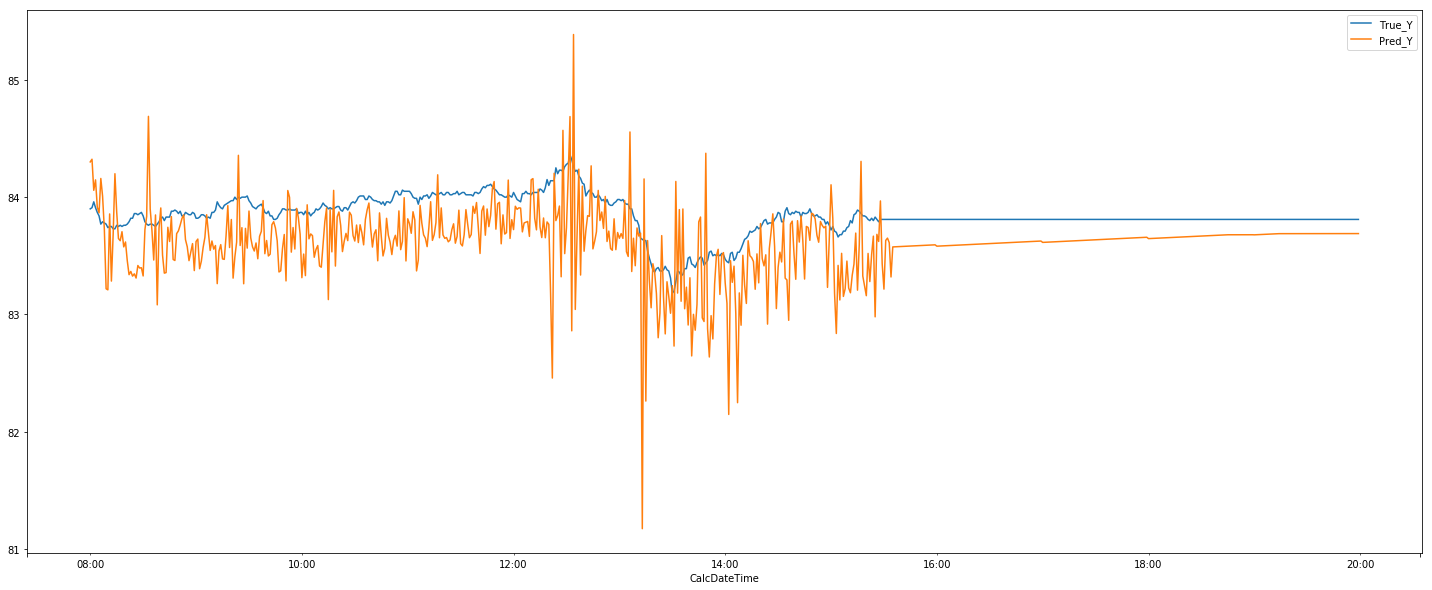

In [29]:
from matplotlib import pyplot as plt

start_loc = test_labels.index.get_loc('2017-07-14 08:00:00')
end_loc = test_labels.index.get_loc('2017-07-14 20:00:00')
data = pd.DataFrame ()
data['True_Y'] = test_labels[start_loc:end_loc]
data['Pred_Y'] = pred[start_loc:end_loc]

data.plot (figsize=(25,10))

---
Extra credit

## Forecasting with CNN

## Forecasting with LSTM

## Forecasting with DeepAR